Auther- Jay Shah
Date-04-26-2024



In [ ]:
import os  # This is a module that provides a way to interact with the operating system
import numpy as np  # NumPy is a library for scientific computing in Python
import matplotlib.pyplot as plt  # Matplotlib is a plotting library for creating visualizations
import torch  # PyTorch is a machine learning library for building and training neural networks
import torch.nn.functional as F  # This module contains PyTorch functions for building neural networks
from torch import nn  # This is the neural network module in PyTorch
import math  # This is a module for mathematical operations
from PIL import Image  # Python Imaging Library (PIL) for working with image files
from torch.optim import Adam  # Adam is an optimization algorithm for training neural networks
from torchvision import transforms  # torchvision provides utilities for working with image data
from torch.utils.data import DataLoader  # DataLoader helps with loading and batching data


**Here I have loaded the dataset**

In [ ]:


# Update DATA_DIR to point to your dataset location in Google Drive
DATA_DIR = '/Users/jayshah/project1/square-triangle'  # This is the path to your dataset

# These are the labels for your dataset
LABELS = ["triangle-bottom-square", "triangle-behind-square", "triangle-infront-square", "triangle-left-square", "triangle-right-square", "triangle-top-square"]




**Here I am doing data pre-processing** Where I am finding lenght of the images then giving them indexs and then flipping them

In [ ]:
from PIL import Image, UnidentifiedImageError  # We import these from PIL for handling image files
# Data Pre-processing:
class CustomDataset(torch.utils.data.Dataset):  # This is a custom dataset class that inherits from PyTorch's Dataset class
    def __init__(self, root_dir, labels, transform=None):
        self.root_dir = root_dir  # This is the directory where your dataset is stored
        self.labels = labels  # These are the labels for your dataset
        self.transform = transform  # These are the transformations to be applied to your images
        self.images = []  # This is a list to store the paths to your images and their corresponding labels

        # This loop goes through each label and finds all the image files for that label
        for label in self.labels:
            label_dir = os.path.join(self.root_dir, label)  # This is the path to the directory for the current label
            for img_file in os.listdir(label_dir):  # This loop goes through all the files in the label directory
                img_path = os.path.join(label_dir, img_file)  # This is the full path to the current image file
                try:
                    # We try to open the file with PIL and convert it to RGB format
                    img = Image.open(img_path).convert("RGB")
                    self.images.append((img_path, label))  # We add the image path and label to the list
                except (IOError, UnidentifiedImageError):
                    # If the file is not an image, we skip it
                    pass

    def __len__(self):
        return len(self.images)  # This returns the number of images in the dataset

    def __getitem__(self, idx):
        img_path, label = self.images[idx]  # This gets the image path and label for the current index
        img = Image.open(img_path).convert("RGB")  # We open the image file and convert it to RGB format
        if self.transform:
            img = self.transform(img)  # If there are transformations, we apply them to the image
        return img, label  # We return the image and its label

# Define data transformations
IMG_SIZE = 64  # This is the size to which we want to resize our images
BATCH_SIZE = 128  # This is the batch size for training

# These are the transformations we want to apply to our images
data_transforms = [
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize the image to the desired size
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally for data augmentation
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Lambda(lambda t: (t * 2) - 1)  # Scale the image pixel values between [-1, 1]
]

data_transform = transforms.Compose(data_transforms)  # We create a composite transformation from the individual transformations

# Load the dataset
dataset = CustomDataset(DATA_DIR, LABELS, transform=data_transform)  # We create an instance of our custom dataset
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)  # We create a data loader for the dataset

**Here I have uploaded the CLIP model which generates vectors on image's pixels and connect them according to text word vectors and make anotther vector which letter can encoded by our prompt words**

In [ ]:
#pre-trained CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)


#Text encoder
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super(TextEncoder, self).__init__()
        self.clip_model =7 clip_model
        self.text_projection = nn.Linear(clip_model.visual.output_dim, 32)

    def forward(self, text):
        text_features = self.clip_model.encode_text(text) 
        text_features = self.text_projection(text_features)
        return text_features


text_encoder = TextEncoder(clip_model).to(device)



**Here I have created simple U-net architecture with the first up sampling the images and then down sampling them which will extract the features of the images**

In [ ]:
#Simple Unet model first up saampling which is encoder than downsampling it which is decoder
class SimpleUnet(nn.Module):
    """ A simplified variant of the Unet architecture. """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([
            Block(down_channels[i], down_channels[i+1], time_emb_dim)
            for i in range(len(down_channels)-1)
        ])

        # Upsample
        self.ups = nn.ModuleList([
            Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True)
            for i in range(len(up_channels)-1)
        ])

    
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)

        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)

        return self.output(x)

# Define the model
model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))

def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

**Timestamps which will go with the images and text input**

In [ ]:
@torch.no_grad()
def sample_timestep(x, t):
    """ Calls the model to predict the noise in the image and returns the denoised image. Applies noise to this image, if we are not in the last step yet. """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    if t == 0:
        
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size))

    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)
    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, dtype=torch.long)
        img = sample_timestep(img, t)
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.squeeze())
    plt.show()
    


In [ ]:
@torch.no_grad()
def generate_text_to_image_samples(text):
    text_tokens = clip.tokenize([text]).to(device)
    text_features = text_encoder(text_tokens)

    #Noise from the output
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)

    
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T / num_images)
    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i / stepsize) + 1)
            show_tensor_image(img.squeeze().detach().cpu())
    plt.show()



**Here I have given the prompt and according to that it will generate better image after 100 epochs**

In [ ]:
text = "square on top of circle"
generate_text_to_image_samples(text)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#optimizer
optimizer = Adam(model.parameters(), lr=0.001)

**Training loop**

Num params:  62438883


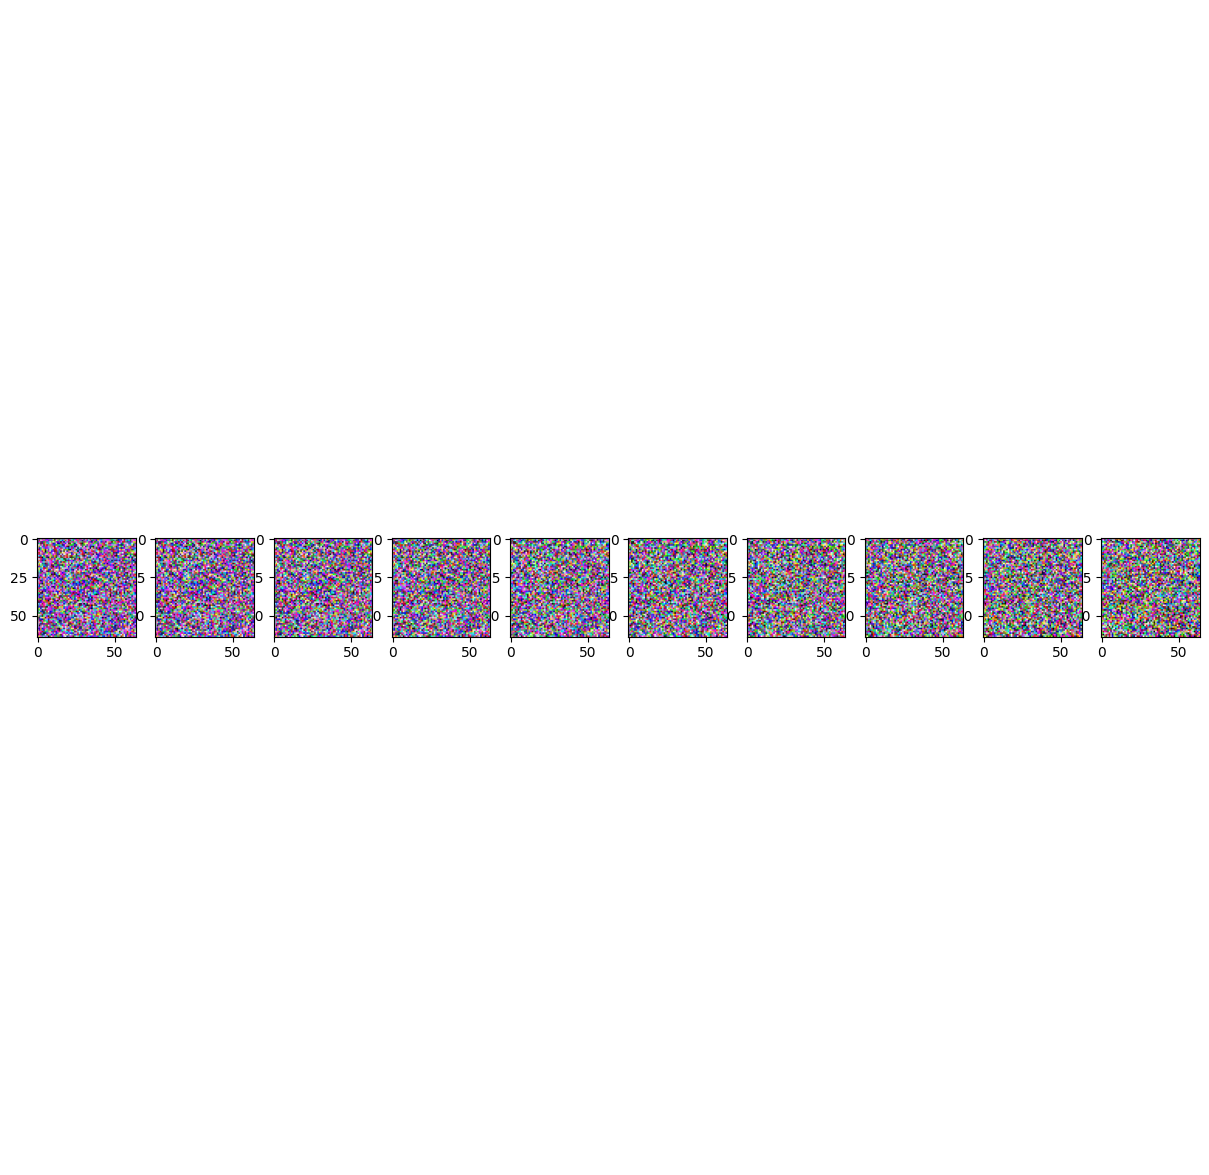

Epoch 0 | step 000 Loss: 0.8129088282585144 
Epoch 5 | step 000 Loss: 0.36663925647735596 
Epoch 10 | step 000 Loss: 0.3029264211654663 
Epoch 15 | step 000 Loss: 0.2790406048297882 
Epoch 20 | step 000 Loss: 0.2303081750869751 
Epoch 25 | step 000 Loss: 0.1989406794309616 
Epoch 30 | step 000 Loss: 0.17979133129119873 
Epoch 35 | step 000 Loss: 0.18216657638549805 
Epoch 40 | step 000 Loss: 0.1634051352739334 
Epoch 45 | step 000 Loss: 0.19522501528263092 
Epoch 50 | step 000 Loss: 0.20741534233093262 
Epoch 55 | step 000 Loss: 0.15522871911525726 
Epoch 60 | step 000 Loss: 0.15327322483062744 
Epoch 65 | step 000 Loss: 0.12805193662643433 
Epoch 70 | step 000 Loss: 0.1252058744430542 
Epoch 75 | step 000 Loss: 0.12491517513990402 
Epoch 80 | step 000 Loss: 0.1108427569270134 
Epoch 85 | step 000 Loss: 0.1150745078921318 
Epoch 90 | step 000 Loss: 0.11720066517591476 
Epoch 95 | step 000 Loss: 0.1098790168762207 


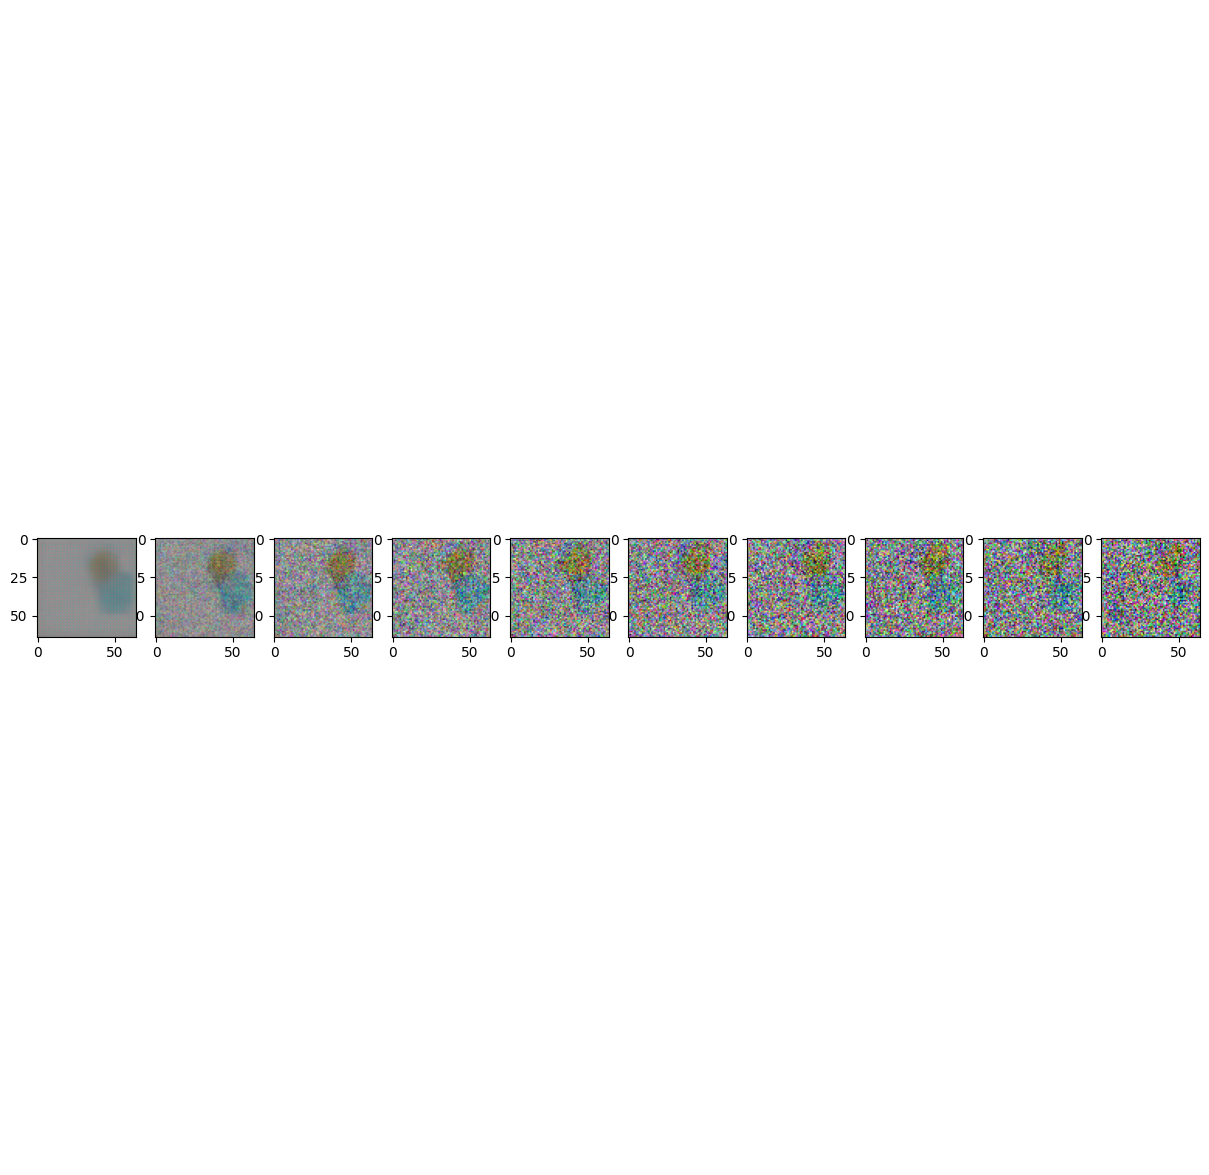

In [30]:

# epochs
epochs = 100

# Training loop
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()
        t = torch.randint(0, T, (BATCH_SIZE,), device=device)
        loss = get_loss(model, batch[0].to(device), t)
        loss.backward()
        optimizer.step()
        if epoch % 5 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")

# Sample and plot images
sample_plot_image()


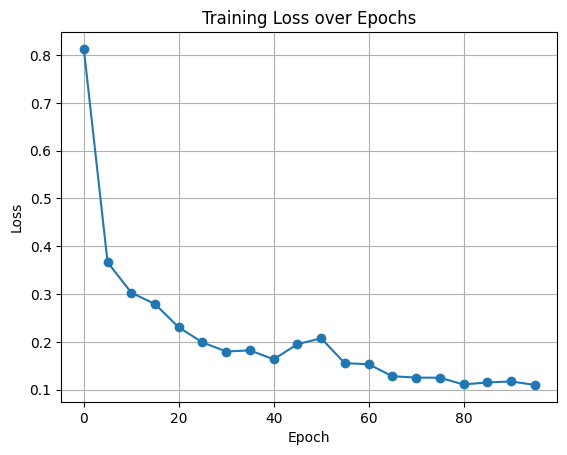